## Task 3

We will train a Convolutional Neural Network on the Breast Cancer dataset obtained from the Kaggle. Before we move onto our analysis, we will read the data into Google Colab. The below code us for reading the data into Colab.

In [0]:
#Importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import glob
import keras
import cv2
from keras import optimizers

In [4]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1eAFE03vsBegi70-DATc3ZelS3edQJ6Qz'
downloaded = drive.CreateFile({'id': file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

    100% |████████████████████████████████| 993kB 27.1MB/s 


In [0]:
fid = drive.ListFile({'q':"title='breast-histopathology-images.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('your_data.zip')

In [6]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

!ls "/content/drive/My Drive/Colab Notebooks/breast-histopathology-images.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
'/content/drive/My Drive/Colab Notebooks/breast-histopathology-images.zip'


In [0]:
#Unzipping the data
import zipfile
import io
zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/breast-histopathology-images.zip", "r").extractall("data")
zipfile.ZipFile("data/IDC_regular_ps50_idx5.zip", "r").extractall("data")

Data upload to Colab is completed, now we will load the data and generate the relevant training and test sets for further processing and model building.

In [0]:
#Extracting the files from the folder
from glob import glob #glob is used to extract the files from a particular folder
Data = glob('data/**/*.png', recursive=True) 

In [0]:
#Generating a random sample of 50000 images since the number of images in the dataset is large and is not computationally supported by Colab
allSample = np.random.choice(Data, 100000)

In [0]:
#Reading the labels of the data from the file name
import csv 
Data_output=list()
Data_output.append(["Classes"])
for file_name in allSample:
    Data_output.append([file_name[-5:-4]])
with open("label.csv", "w") as f:
    writer = csv.writer(f)
    for val in Data_output:
        writer.writerows([val])
        
y = pd.read_csv('label.csv')

We will now undersample the data to ensure that we have equal number of samples for both the classes. Not that since we undersample the data such that both classes have the same number of samples, we will use **Accuracy** as the metric to measure the performance.

In [14]:
#Undersampling the data
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(replacement=False)
X_subsample, y_subsample = rus.fit_sample(
    np.array(allSample).reshape(-1, 1), y)
print(X_subsample.shape)
print(y_subsample.shape)

(56778, 1)
(56778, 1)


Now that we have undersampled, we will read these images into the notebook and while reading, we will ensure that each of the image has been resized to (50,50) as per the description in the dataset.

In [15]:
#Reading the images and converting them to a size of 50x50 as per the definition from the data
from keras.preprocessing import image
from tqdm import tqdm
X = []
for i in tqdm(X_subsample):
  img = image.load_img(i[0], target_size=(50, 50))
  X.append(image.img_to_array(img))
 
X = np.array(X)

100%|██████████| 56778/56778 [00:21<00:00, 2610.23it/s]


Now that we have read, process and reshaped the data, lets us plot some image (first 25 images) to see that process and unprocess images look the same.

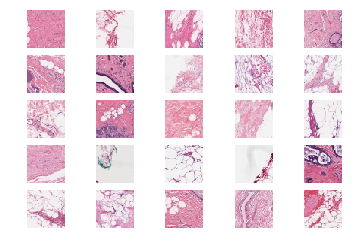

In [16]:
#function source: https://www.kaggle.com/animeshseemendra/breast-cancer-detection-idc
def plot_images(photos) : #to plot multiple image
    x=0
    for image in photos:
        image_cv = cv2.imread(image[0])
        plt.subplot(5, 5, x+1)
        plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB));
        plt.axis('off');
        x+=1
plot_images(X_subsample[:25])

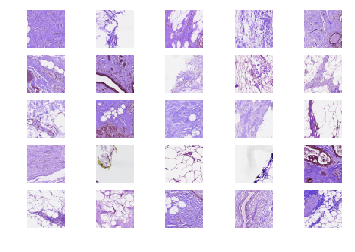

In [17]:
#function source: https://www.kaggle.com/animeshseemendra/breast-cancer-detection-idc
def plot_images2(photos) : #to plot multiple image
    x=0
    for image in photos:
        plt.subplot(5, 5, x+1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));
        plt.axis('off');
        x+=1
plot_images2(X[:25]/255) #Note we are dividing the matrix by 255

As we can see, the processed images are same as the orginal images.

Let us now split our final sample into train and test sets. We will divide our features by 255  (similar to the above) to normalize them and also one hot encode our output so that it can be read by Keras.

In [0]:
#Splitting the undersampled data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_subsample)
y_train = keras.utils.to_categorical(y_train, 2)
X_train = X_train/255

## 3.1

In this section, we will start with a basic model without any residual connections.

Our first model will be a  Convolutional Neural Network with 2 Dense Layers, 2 Conv2D laters and 2 MaxPooling layers. In the implementation, we will incorporate Batch Normalization without the Dropout and see how our model performs.

We are also training the model with  a reduced learning rate of 0.00005 

In [24]:
#Running a CNN with Batch Normalization and without Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dropout, BatchNormalization
from keras import optimizers

cnn = Sequential()
cnn.add(Conv2D(8, kernel_size=(3, 3),
                 input_shape=(50,50,3)))
cnn.add(Activation("relu"))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(8, (3, 3)))
cnn.add(Activation("relu"))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(2, activation='softmax'))

adam = optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

cnn.compile(optimizer=adam, loss="categorical_crossentropy", metrics=['accuracy'])

history_cnn = cnn.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1,
          validation_split=.1)

Train on 38589 samples, validate on 4288 samples
Epoch 1/25
38589/38589 [==============================] - 6s 147us/step - loss: 0.6292 - acc: 0.7148 - val_loss: 0.5875 - val_acc: 0.7414
Epoch 2/25
38589/38589 [==============================] - 5s 121us/step - loss: 0.5072 - acc: 0.7736 - val_loss: 0.5188 - val_acc: 0.7668
Epoch 3/25
38589/38589 [==============================] - 5s 120us/step - loss: 0.4760 - acc: 0.7881 - val_loss: 0.4916 - val_acc: 0.7799
Epoch 4/25
38589/38589 [==============================] - 5s 119us/step - loss: 0.4583 - acc: 0.7986 - val_loss: 0.4798 - val_acc: 0.7861
Epoch 5/25
38589/38589 [==============================] - 5s 120us/step - loss: 0.4468 - acc: 0.8031 - val_loss: 0.4712 - val_acc: 0.7901
Epoch 6/25
38589/38589 [==============================] - 5s 119us/step - loss: 0.4364 - acc: 0.8080 - val_loss: 0.4617 - val_acc: 0.7943
Epoch 7/25
38589/38589 [==============================] - 5s 120us/step - loss: 0.4272 - acc: 0.8124 - val_loss: 0.4603 - v

In [25]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 48, 48, 8)         224       
_________________________________________________________________
activation_11 (Activation)   (None, 48, 48, 8)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 48, 48, 8)         32        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 22, 22, 8)         584       
_________________________________________________________________
activation_12 (Activation)   (None, 22, 22, 8)         0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 22, 22, 8)         32        
__________

Let us now plot the Accuracy and Loss on the training and validation set against the number of Epochs.

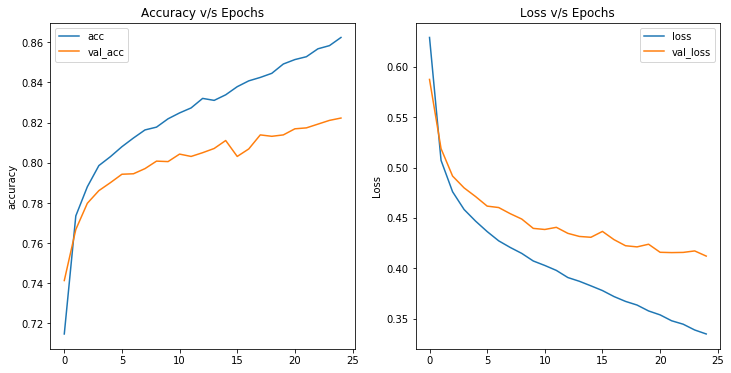

In [26]:
#Let us now plot and visulize the results

fig, ax = plt.subplots(1,2, figsize=(12,6))
df = pd.DataFrame(history_cnn.history)
_ = ax[0].plot(df.acc)
_ = ax[0].plot(df['val_acc'])
_ = ax[1].plot(df.loss)
_ = ax[1].plot(df['val_loss'])
_ = ax[1].set_ylabel("Loss")
_ = ax[0].set_ylabel("accuracy")
_ = ax[0].legend()
_ = ax[1].legend()
_ = ax[0].set_title("Accuracy v/s Epochs")
_ = ax[1].set_title("Loss v/s Epochs")

As we can see from the above, the accuracy constantly increases. Similarly, training loss constantly decreases with the number of epochs whereas the validation loss shows a high variance.

Also, we can see a clear evidence of overfitting as the accuracy and loss for training set reaches the best values whereas for the test set, it tapers off at some point.

In the next model, we will implement the same model but with a 30% dropout at every layer to reduce overfitting. We want to study if this has a significant impact on the performance of our model.

In [28]:
#Running a CNN with Batch Normalization and with Dropout

cnn_drop = Sequential()
cnn_drop.add(Conv2D(8, kernel_size=(3, 3),
                 input_shape=(50,50,3)))
cnn_drop.add(Activation("relu"))
cnn_drop.add(BatchNormalization())
cnn_drop.add(MaxPooling2D(pool_size=(2, 2)))
cnn_drop.add(Dropout(0.3))
cnn_drop.add(Conv2D(8, (3, 3)))
cnn_drop.add(Activation("relu"))
cnn_drop.add(BatchNormalization())
cnn_drop.add(MaxPooling2D(pool_size=(2, 2)))
cnn_drop.add(Dropout(0.3))
cnn_drop.add(Flatten())
cnn_drop.add(Dense(64, activation='relu'))
cnn_drop.add(Dense(2, activation='softmax'))

adam = optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

cnn_drop.compile(optimizer=adam, loss="categorical_crossentropy", metrics=['accuracy'])

history_cnn_dropout = cnn_drop.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1,
          validation_split=.1)

Train on 38589 samples, validate on 4288 samples
Epoch 1/25
38589/38589 [==============================] - 6s 157us/step - loss: 0.8579 - acc: 0.6375 - val_loss: 0.6542 - val_acc: 0.6616
Epoch 2/25
38589/38589 [==============================] - 5s 123us/step - loss: 0.6260 - acc: 0.7146 - val_loss: 0.5376 - val_acc: 0.7551
Epoch 3/25
38589/38589 [==============================] - 5s 122us/step - loss: 0.5575 - acc: 0.7446 - val_loss: 0.4948 - val_acc: 0.7757
Epoch 4/25
38589/38589 [==============================] - 5s 122us/step - loss: 0.5179 - acc: 0.7662 - val_loss: 0.4799 - val_acc: 0.7850
Epoch 5/25
38589/38589 [==============================] - 5s 123us/step - loss: 0.4985 - acc: 0.7755 - val_loss: 0.4687 - val_acc: 0.7901
Epoch 6/25
38589/38589 [==============================] - 5s 123us/step - loss: 0.4830 - acc: 0.7843 - val_loss: 0.4592 - val_acc: 0.7948
Epoch 7/25
38589/38589 [==============================] - 5s 122us/step - loss: 0.4711 - acc: 0.7913 - val_loss: 0.4697 - v

In [29]:
cnn_drop.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 48, 48, 8)         224       
_________________________________________________________________
activation_15 (Activation)   (None, 48, 48, 8)         0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 48, 48, 8)         32        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 24, 24, 8)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 22, 22, 8)         584       
_________________________________________________________________
activation_16 (Activation)   (None, 22, 22, 8)         0         
__________

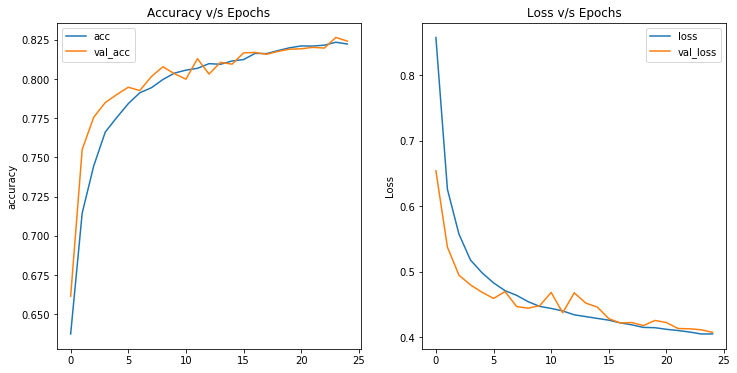

In [30]:
#Let us now plot and visulize the results

fig, ax = plt.subplots(1,2, figsize=(12,6))
df = pd.DataFrame(history_cnn_dropout.history)
_ = ax[0].plot(df.acc)
_ = ax[0].plot(df['val_acc'])
_ = ax[1].plot(df.loss)
_ = ax[1].plot(df['val_loss'])
_ = ax[1].set_ylabel("Loss")
_ = ax[0].set_ylabel("accuracy")
_ = ax[0].legend()
_ = ax[1].legend()
_ = ax[0].set_title("Accuracy v/s Epochs")
_ = ax[1].set_title("Loss v/s Epochs")

As we can see from the above, in the model with dropout, we are able to reduce the overfitting of the model as the training accuracy is parked at around 85% which is near the test accuracy. However from our run, we notice that the training time for this model is higher. This is due to the fact that dropout has to perform random drops at every layer to minimize overfitting, which leads to a higher running time.

## 3.2

In this section, we will augment the data using various transformation such as rotations, mirroring etc on the images. We want to see whether these transformations improve the performance of the model that we devised in the previous section.

The augmentations that we will be performing are:

- shear_range: for changing the shear intensity
- rotation_range: rotating the image by certain angle
- zoom_range: we will be zooming out the range
- horizontal/vertical_flip: flipping the images randomly in either directions
- rescale: since we have already rescaled the data by dividing by 255, we will not further recale
- width/height_shift_range: to randomly shift the with and height by certain amount.

Note that the values used are chosen randomly/based on intuition due to long training time while implementing GridSearchCV in Keras and given the amount of data.

We will use Batch Normalization and Dropout as continued form the previous part as it reduces overfitting.

In [0]:
#Splitting the training set into training and validation set for augmentation, maintaining a validation size of 0.1
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_train, y_train, test_size=0.1)

In [0]:
#Creating the ImageDataGenerator object with all the parameters
from keras.preprocessing.image import ImageDataGenerator
imageGen = ImageDataGenerator(
        shear_range=0.3,
        rotation_range=50,
        zoom_range=0.5,
        horizontal_flip=True,
        width_shift_range=0.25,
        height_shift_range=0.25,
        vertical_flip=True)

In [34]:
#Building and fitting the model with the augmented data and testing on the validation data. Note that the steps per epoch taken are 200
#based on heuristics. This is approximately the number of samples in the training data divided by the batch size.

cnn_augment = Sequential()
cnn_augment.add(Conv2D(8, kernel_size=(3, 3),
                 input_shape=(50,50,3)))
cnn_augment.add(Activation("relu"))
cnn_augment.add(BatchNormalization())
cnn_augment.add(MaxPooling2D(pool_size=(2, 2)))
cnn_drop.add(Dropout(0.3))
cnn_augment.add(Conv2D(8, (3, 3)))
cnn_augment.add(Activation("relu"))
cnn_augment.add(BatchNormalization())
cnn_augment.add(MaxPooling2D(pool_size=(2, 2)))
cnn_drop.add(Dropout(0.3))
cnn_augment.add(Flatten())
cnn_augment.add(Dense(64, activation='relu'))
cnn_augment.add(Dense(2, activation='softmax'))

cnn_augment.compile(optimizer=adam, loss="categorical_crossentropy", metrics=['accuracy'])
history_cnn_augment = cnn_augment.fit_generator(imageGen.flow(X_train_aug, y_train_aug, batch_size=128), epochs=25, verbose=1,
          validation_data=(X_val_aug, y_val_aug), steps_per_epoch=200)

Epoch 1/25
200/200 [==============================] - 27s 133ms/step - loss: 0.5407 - acc: 0.7548 - val_loss: 0.5282 - val_acc: 0.7768
Epoch 2/25
200/200 [==============================] - 25s 125ms/step - loss: 0.4881 - acc: 0.7803 - val_loss: 0.5767 - val_acc: 0.7570
Epoch 3/25
200/200 [==============================] - 25s 126ms/step - loss: 0.4720 - acc: 0.7884 - val_loss: 0.4739 - val_acc: 0.7899
Epoch 4/25
200/200 [==============================] - 25s 127ms/step - loss: 0.4642 - acc: 0.7935 - val_loss: 0.4679 - val_acc: 0.7906
Epoch 5/25
200/200 [==============================] - 25s 126ms/step - loss: 0.4598 - acc: 0.7948 - val_loss: 0.4885 - val_acc: 0.7868
Epoch 6/25
200/200 [==============================] - 25s 127ms/step - loss: 0.4447 - acc: 0.8022 - val_loss: 0.5033 - val_acc: 0.7801
Epoch 7/25
200/200 [==============================] - 25s 127ms/step - loss: 0.4436 - acc: 0.8027 - val_loss: 0.4795 - val_acc: 0.7871
Epoch 8/25
200/200 [==============================] - 2

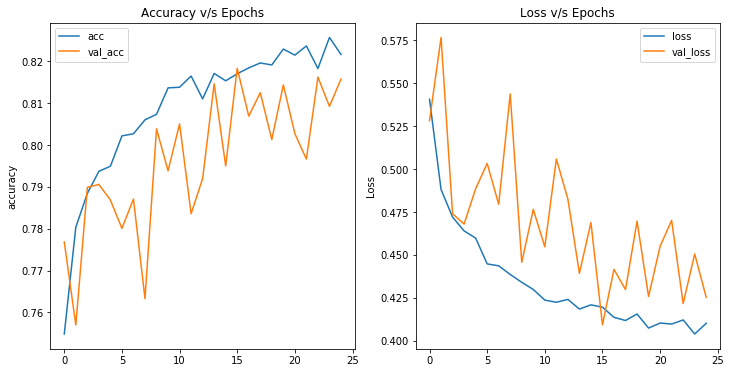

In [35]:
#Let us now plot and visulize the results
fig, ax = plt.subplots(1,2, figsize=(12,6))
df = pd.DataFrame(history_cnn_augment.history)
_ = ax[0].plot(df.acc)
_ = ax[0].plot(df['val_acc'])
_ = ax[1].plot(df.loss)
_ = ax[1].plot(df['val_loss'])
_ = ax[1].set_ylabel("Loss")
_ = ax[0].set_ylabel("accuracy")
_ = ax[0].legend()
_ = ax[1].legend()
_ = ax[0].set_title("Accuracy v/s Epochs")
_ = ax[1].set_title("Loss v/s Epochs")

We see a slightly improved performance from the previous part where we did not augment the data. The loss seems to have lesser variance and accuracy shows a very slight improvement in the performance.

We will now implement several more convolutions, followed by a single max pooling layer and then 2 dense layers. Again, this is just based on intuition, where we are trying multiple architecture to obtain a model that is significantly better than our previous models.

In [39]:
#Building and fitting the model with the augmented data and testing on the validation data. Note that the steps per epoch taken are 200
#based on heuristics. This is approximately the number of samples in the training data divided by the batch size.

cnn_augment_layers = Sequential()
cnn_augment_layers.add(Conv2D(32, kernel_size=(3, 3),
                 input_shape=(50,50,3)))
cnn_augment_layers.add(BatchNormalization())
cnn_augment_layers.add(Activation("relu"))
cnn_augment_layers.add(Conv2D(16, (3, 3)))
cnn_augment_layers.add(BatchNormalization())
cnn_augment_layers.add(Activation("relu"))
cnn_augment_layers.add(Conv2D(16, (3, 3)))
cnn_augment_layers.add(BatchNormalization())
cnn_augment_layers.add(Activation("relu"))
cnn_augment_layers.add(Conv2D(8, (3, 3)))
cnn_augment_layers.add(BatchNormalization())
cnn_augment_layers.add(Activation("relu"))
cnn_augment_layers.add(MaxPooling2D(pool_size=(2, 2)))
cnn_augment_layers.add(Flatten())
cnn_augment_layers.add(Dense(64, activation='relu'))
cnn_augment_layers.add(Dense(2, activation='softmax'))

cnn_augment_layers.compile(optimizer=adam, loss="categorical_crossentropy", metrics=['accuracy'])

history_cnn_augment_layers = cnn_augment_layers.fit_generator(imageGen.flow(X_train_aug, y_train_aug, batch_size=128), epochs=20, verbose=1,
          validation_data=(X_val_aug, y_val_aug), steps_per_epoch=200)

Epoch 1/20
200/200 [==============================] - 31s 157ms/step - loss: 0.5041 - acc: 0.7701 - val_loss: 0.4737 - val_acc: 0.7962
Epoch 2/20
200/200 [==============================] - 28s 141ms/step - loss: 0.4289 - acc: 0.8136 - val_loss: 0.5223 - val_acc: 0.7801
Epoch 3/20
200/200 [==============================] - 28s 141ms/step - loss: 0.4189 - acc: 0.8182 - val_loss: 0.6663 - val_acc: 0.7409
Epoch 4/20
200/200 [==============================] - 29s 144ms/step - loss: 0.4122 - acc: 0.8207 - val_loss: 0.4371 - val_acc: 0.8137
Epoch 5/20
200/200 [==============================] - 28s 140ms/step - loss: 0.4092 - acc: 0.8203 - val_loss: 0.3942 - val_acc: 0.8342
Epoch 6/20
200/200 [==============================] - 29s 146ms/step - loss: 0.3972 - acc: 0.8317 - val_loss: 0.4403 - val_acc: 0.8186
Epoch 7/20
200/200 [==============================] - 28s 142ms/step - loss: 0.3965 - acc: 0.8272 - val_loss: 0.3985 - val_acc: 0.8354
Epoch 8/20
200/200 [==============================] - 2

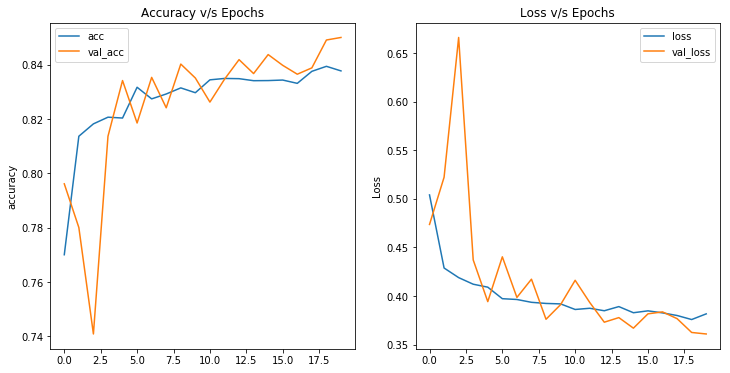

In [40]:
#Let us now plot and visulize the results
fig, ax = plt.subplots(1,2, figsize=(12,6))
df = pd.DataFrame(history_cnn_augment_layers.history)
_ = ax[0].plot(df.acc)
_ = ax[0].plot(df['val_acc'])
_ = ax[1].plot(df.loss)
_ = ax[1].plot(df['val_loss'])
_ = ax[1].set_ylabel("Loss")
_ = ax[0].set_ylabel("accuracy")
_ = ax[0].legend()
_ = ax[1].legend()
_ = ax[0].set_title("Accuracy v/s Epochs")
_ = ax[1].set_title("Loss v/s Epochs")

Again, by increasing the number of convolutions, we do not see any significant jump in the performance of our model. Our previous model that had less number of convolutions and more maxpooling between the convolutions performed similar if not better than the above model.

## 3.3

In this section, we will construct a Residual Neural Network that is deep with about 10 layers, 1 input layer and 2 dense layers (including output). We will see how it compares to a model without the Residual connections with the same architecture.



First, we will train a residual net with the above configurations without Batch Normalization and Dropout to see what the performance is.

### Residual Net

In [0]:
#Training ResNet without Batch Normalization or Dropout

from keras.layers import Input, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

num_classes = 2

inputs = Input(shape=(50, 50, 3))
conv1_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(inputs)
conv1_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv1_1)

maxpool1 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(conv1_2)

conv2_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool1)
conv2_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv2_1)

skip2 = keras.layers.Add()([maxpool1, conv2_2])

maxpool2 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip2)
conv3_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool2)
conv3_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv3_1)

skip3 = keras.layers.Add()([maxpool2, conv3_2])

maxpool3 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip3)
conv4_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool3)
conv4_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv4_1)

skip4 = keras.layers.Add()([maxpool3, conv4_2])

maxpool4 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip4)
conv5_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool4)
conv5_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv5_1)

skip5 = keras.layers.Add()([maxpool4, conv5_2])

maxpool5 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip5)

conv6_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool5)
conv6_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv6_1)

skip6 = keras.layers.Add()([maxpool5, conv6_2])

maxpool6 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip6)
conv7_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool6)
conv7_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv7_1)

skip7 = keras.layers.Add()([maxpool6, conv7_2])


maxpool7 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip7)
conv8_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool7)
conv8_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv8_1)

skip8 = keras.layers.Add()([maxpool7, conv8_2])

maxpool8 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip8)
conv9_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool8)
conv9_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv9_1)

skip9 = keras.layers.Add()([maxpool8, conv9_2])

maxpool9 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip9)
conv10_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool9)
conv10_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv10_1)

skip10 = keras.layers.Add()([maxpool9, conv10_2])

maxpool10 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip10)
adam = optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


flat = Flatten()(maxpool5)
dense = Dense(12, activation='relu')(flat)
predictions = Dense(num_classes, activation='softmax')(dense)
model_rnn_base = Model(inputs=inputs, outputs=predictions)
#model.summary()

In [24]:
model_rnn_base.compile(optimizer=adam, loss="categorical_crossentropy", metrics=['accuracy'])

history_model_rnn_base = model_rnn_base.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
          validation_split=.1) 

Instructions for updating:
Use tf.cast instead.
Train on 38324 samples, validate on 4259 samples
Epoch 1/20
38324/38324 [==============================] - 14s 367us/step - loss: 0.6036 - acc: 0.6920 - val_loss: 0.5046 - val_acc: 0.7622
Epoch 2/20
38324/38324 [==============================] - 8s 197us/step - loss: 0.4781 - acc: 0.7825 - val_loss: 0.4583 - val_acc: 0.7924
Epoch 3/20
38324/38324 [==============================] - 8s 198us/step - loss: 0.4582 - acc: 0.7949 - val_loss: 0.4470 - val_acc: 0.8002
Epoch 4/20
38324/38324 [==============================] - 8s 198us/step - loss: 0.4478 - acc: 0.8009 - val_loss: 0.4399 - val_acc: 0.8063
Epoch 5/20
38324/38324 [==============================] - 8s 200us/step - loss: 0.4451 - acc: 0.7991 - val_loss: 0.4358 - val_acc: 0.8082
Epoch 6/20
38324/38324 [==============================] - 8s 201us/step - loss: 0.4395 - acc: 0.8041 - val_loss: 0.4630 - val_acc: 0.7892
Epoch 7/20
38324/38324 [==============================] - 8s 203us/step - 

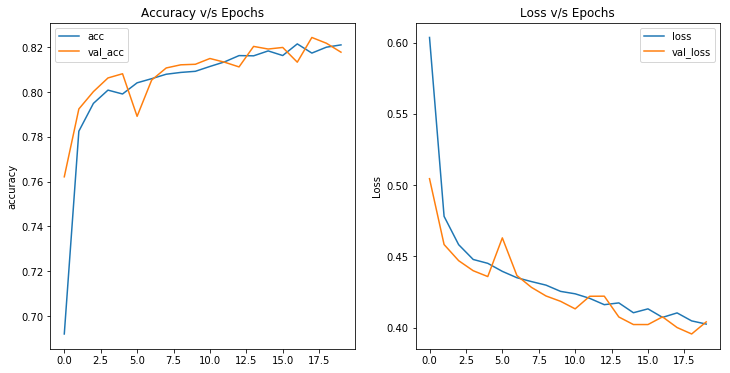

In [25]:
#Let us now plot and visulize the results
fig, ax = plt.subplots(1,2, figsize=(12,6))
df = pd.DataFrame(history_model_rnn_base.history)
_ = ax[0].plot(df.acc)
_ = ax[0].plot(df['val_acc'])
_ = ax[1].plot(df.loss)
_ = ax[1].plot(df['val_loss'])
_ = ax[1].set_ylabel("Loss")
_ = ax[0].set_ylabel("accuracy")
_ = ax[0].legend()
_ = ax[1].legend()
_ = ax[0].set_title("Accuracy v/s Epochs")
_ = ax[1].set_title("Loss v/s Epochs")

As we can see from the above results, the accuracy and the loss hass much less variance compared to the previous models and at the same time have better values. However, note that we can clearly see signs of overfitting in the training and validation curves.

We will now develop on the above model to include Batch Normalization for each of the convolutions and see if that regularizes our model and reduces the overfitting.

In [0]:
#Building ResNet with Batch Normalization
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.models import Model

num_classes = 2

inputs = Input(shape=(50, 50, 3))
conv1_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(inputs)

bat1_1 = BatchNormalization()(conv1_1)

conv1_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv1_1)

bat1_2 = BatchNormalization()(conv1_2)

maxpool1 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(bat1_2)

conv2_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool1)

bat2_1 = BatchNormalization()(conv2_1)

conv2_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv2_1)

bat2_2 = BatchNormalization()(conv2_2)

skip2 = keras.layers.Add()([maxpool1, bat2_2])

maxpool2 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip2)
conv3_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool2)

bat3_1 = BatchNormalization()(conv3_1)

conv3_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv3_1)

bat3_2 = BatchNormalization()(conv3_2)

skip3 = keras.layers.Add()([maxpool2, bat3_2])

maxpool3 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip3)
conv4_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool3)

bat4_1 = BatchNormalization()(conv4_1)

conv4_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv4_1)

bat4_2 = BatchNormalization()(conv4_2)

skip4 = keras.layers.Add()([maxpool3, bat4_2])

maxpool4 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip4)
conv5_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool4)
bat5_1 = BatchNormalization()(conv5_1)

conv5_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat5_1)

bat5_2 = BatchNormalization()(conv5_2)

skip5 = keras.layers.Add()([maxpool4, bat5_2])

maxpool5 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip5)

conv6_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool5)

bat6_1 = BatchNormalization()(conv6_1)

conv6_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat6_1)

bat6_2 = BatchNormalization()(conv2_2)

skip6 = keras.layers.Add()([maxpool1, bat6_2])

maxpool6 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip6)
conv7_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool6)

bat7_1 = BatchNormalization()(conv7_1)

conv7_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat7_1)

bat7_2 = BatchNormalization()(conv7_2)

skip7 = keras.layers.Add()([maxpool6, bat7_2])

maxpool7 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip7)
conv8_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool7)

bat8_1 = BatchNormalization()(conv8_1)

conv8_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat8_1)

bat8_2 = BatchNormalization()(conv8_2)

skip8 = keras.layers.Add()([maxpool7, bat8_2])

maxpool8 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip8)
conv9_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool8)
bat9_1 = BatchNormalization()(conv9_1)

conv9_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat9_1)

bat9_2 = BatchNormalization()(conv9_2)

skip9 = keras.layers.Add()([maxpool8, bat9_2])

maxpool9 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip9)
conv10_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool9)
bat10_1 = BatchNormalization()(conv10_1)

conv10_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat10_1)

bat10_2 = BatchNormalization()(conv10_2)

skip10 = keras.layers.Add()([maxpool9, bat10_2])


maxpool10 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip10)


flat = Flatten()(maxpool10)
dense = Dense(12, activation='relu')(flat)
predictions = Dense(num_classes, activation='softmax')(dense)
model_rnn_BN = Model(inputs=inputs, outputs=predictions)
#model.summary()

In [30]:
model_rnn_BN.compile(optimizer=adam, loss="categorical_crossentropy", metrics=['accuracy'])

history_model_rnn_BN = model_rnn_BN.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
          validation_split=.1) 

Train on 38324 samples, validate on 4259 samples
Epoch 1/20
38324/38324 [==============================] - 14s 370us/step - loss: 0.6867 - acc: 0.7808 - val_loss: 0.4622 - val_acc: 0.7903
Epoch 2/20
38324/38324 [==============================] - 11s 286us/step - loss: 0.4071 - acc: 0.8215 - val_loss: 0.4117 - val_acc: 0.8183
Epoch 3/20
38324/38324 [==============================] - 11s 280us/step - loss: 0.3888 - acc: 0.8322 - val_loss: 0.4171 - val_acc: 0.8115
Epoch 4/20
38324/38324 [==============================] - 11s 277us/step - loss: 0.3754 - acc: 0.8382 - val_loss: 0.3939 - val_acc: 0.8258
Epoch 5/20
38324/38324 [==============================] - 11s 280us/step - loss: 0.3650 - acc: 0.8431 - val_loss: 0.3914 - val_acc: 0.8277
Epoch 6/20
38324/38324 [==============================] - 11s 282us/step - loss: 0.3562 - acc: 0.8486 - val_loss: 0.3928 - val_acc: 0.8244
Epoch 7/20
38324/38324 [==============================] - 11s 276us/step - loss: 0.3480 - acc: 0.8507 - val_loss: 0.3

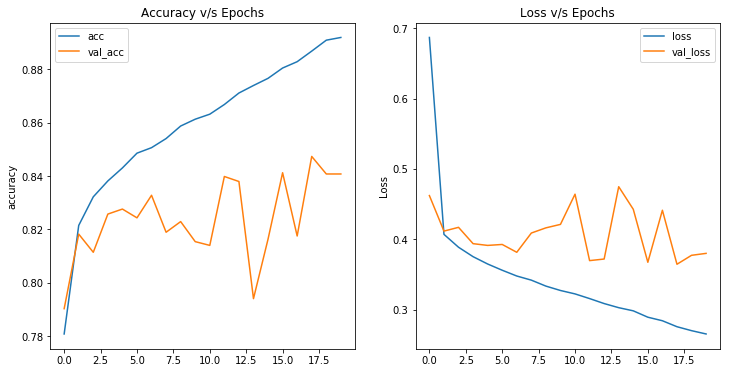

In [32]:
#Let us now plot and visulize the results
fig, ax = plt.subplots(1,2, figsize=(12,6))
df = pd.DataFrame(history_model_rnn_BN.history)
_ = ax[0].plot(df.acc)
_ = ax[0].plot(df['val_acc'])
_ = ax[1].plot(df.loss)
_ = ax[1].plot(df['val_loss'])
_ = ax[1].set_ylabel("Loss")
_ = ax[0].set_ylabel("accuracy")
_ = ax[0].legend()
_ = ax[1].legend()
_ = ax[0].set_title("Accuracy v/s Epochs")
_ = ax[1].set_title("Loss v/s Epochs")

From the above, we can see that there is a slight decrease in overfitting (particularly around the loss values). However, the performance of our model decreases by using Batch Normalization.

Next, we will try to reduce overfitting by using Dropout. 30% Dropout will be used with each layer.

In [0]:
#ResNet with 30% Dropout
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Model

num_classes = 2

inputs = Input(shape=(50, 50, 3))
conv1_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(inputs)

bat1_1 = Dropout(0.3)(conv1_1)

conv1_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat1_1)

bat1_2 = Dropout(0.3)(conv1_2)

maxpool1 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(bat1_2)

conv2_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool1)

bat2_1 = Dropout(0.3)(conv2_1)

conv2_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv2_1)

bat2_2 = Dropout(0.3)(conv2_2)

skip2 = keras.layers.Add()([maxpool1, bat2_2])

maxpool2 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip2)
conv3_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool2)

bat3_1 = Dropout(0.3)(conv3_1)

conv3_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat3_1)

bat3_2 = Dropout(0.3)(conv3_2)

skip3 = keras.layers.Add()([maxpool2, bat3_2])

maxpool3 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip3)
conv4_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool3)

bat4_1 = Dropout(0.3)(conv4_1)

conv4_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat4_1)

bat4_2 = Dropout(0.3)(conv4_2)

skip4 = keras.layers.Add()([maxpool3, bat4_2])

maxpool4 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip4)
conv5_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool4)
bat5_1 = Dropout(0.3)(conv5_1)

conv5_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat5_1)

bat5_2 = Dropout(0.3)(conv5_2)

skip5 = keras.layers.Add()([maxpool4, bat5_2])

maxpool5 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip5)

conv6_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool5)

bat6_1 = Dropout(0.3)(conv6_1)

conv6_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv6_1)

bat6_2 = Dropout(0.3)(conv6_2)

skip6 = keras.layers.Add()([maxpool5, bat6_2])

maxpool6 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip6)
conv7_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool6)

bat7_1 = Dropout(0.3)(conv7_1)

conv7_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat7_1)

bat7_2 = Dropout(0.3)(conv7_2)

skip7 = keras.layers.Add()([maxpool6, bat7_2])

maxpool7 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip7)
conv8_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool7)
bat8_1 = Dropout(0.3)(conv8_1)

conv8_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat8_1)

bat8_2 = Dropout(0.3)(conv8_2)

skip8 = keras.layers.Add()([maxpool7, bat8_2])

maxpool8 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip8)

conv9_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool8)
bat9_1 = Dropout(0.3)(conv9_1)

conv9_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat9_1)

bat9_2 = Dropout(0.3)(conv9_2)

skip9 = keras.layers.Add()([maxpool8, bat9_2])

maxpool9 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip9)

conv10_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool9)
bat10_1 = Dropout(0.3)(conv10_1)

conv10_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat10_1)

bat10_2 = Dropout(0.3)(conv10_2)

skip10 = keras.layers.Add()([maxpool9, bat10_2])

maxpool10 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(skip10)

flat = Flatten()(maxpool10)
dense = Dense(12, activation='relu')(flat)
predictions = Dense(num_classes, activation='softmax')(dense)
model_rnn_drop = Model(inputs=inputs, outputs=predictions)
#model.summary()

In [39]:

model_rnn_drop.compile(optimizer=adam, loss="categorical_crossentropy", metrics=['accuracy'])

history_model_rnn_drop = model_rnn_drop.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
          validation_split=.1) 

Train on 38324 samples, validate on 4259 samples
Epoch 1/20
38324/38324 [==============================] - 17s 444us/step - loss: 0.7072 - acc: 0.5097 - val_loss: 0.6908 - val_acc: 0.6680
Epoch 2/20
38324/38324 [==============================] - 14s 356us/step - loss: 0.5751 - acc: 0.7032 - val_loss: 0.6079 - val_acc: 0.7302
Epoch 3/20
38324/38324 [==============================] - 14s 356us/step - loss: 0.4818 - acc: 0.7860 - val_loss: 0.6022 - val_acc: 0.7633
Epoch 4/20
38324/38324 [==============================] - 14s 359us/step - loss: 0.4682 - acc: 0.7918 - val_loss: 0.6066 - val_acc: 0.7638
Epoch 5/20
38324/38324 [==============================] - 14s 353us/step - loss: 0.4604 - acc: 0.7953 - val_loss: 0.5980 - val_acc: 0.7795
Epoch 6/20
38324/38324 [==============================] - 14s 353us/step - loss: 0.4553 - acc: 0.7990 - val_loss: 0.5918 - val_acc: 0.7840
Epoch 7/20
38324/38324 [==============================] - 14s 354us/step - loss: 0.4514 - acc: 0.7989 - val_loss: 0.5

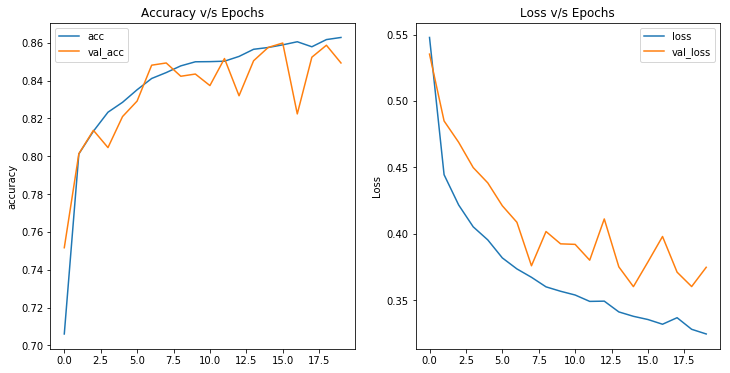

In [98]:
#Let us now plot and visulize the results
fig, ax = plt.subplots(1,2, figsize=(12,6))
df = pd.DataFrame(history_model_rnn_drop.history)
_ = ax[0].plot(df.acc)
_ = ax[0].plot(df['val_acc'])
_ = ax[1].plot(df.loss)
_ = ax[1].plot(df['val_loss'])
_ = ax[1].set_ylabel("Loss")
_ = ax[0].set_ylabel("accuracy")
_ = ax[0].legend()
_ = ax[1].legend()
_ = ax[0].set_title("Accuracy v/s Epochs")
_ = ax[1].set_title("Loss v/s Epochs")

As we can see from the above results, the overfitting is reduced significantly. Furthermore, we are able to achieve about 85% accuracy on the validation set.

Now, with the same configurations as the best model obtained above, we will build a deep model without the residual connections. Rest of the architechture would remain the same as the above model with 30% dropout.

### Regular CNN without Residuals

In [0]:
#Building a Deep Model without Residual Connections

from keras.layers import Input, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

num_classes = 2

inputs = Input(shape=(50, 50, 3))
conv1_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(inputs)

bat1_1 = Dropout(0.3)(conv1_1)

conv1_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv1_1)

bat1_2 = Dropout(0.3)(conv1_2)

maxpool1 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(bat1_2)

conv2_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool1)

bat2_1 = Dropout(0.3)(conv2_1)

conv2_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv2_1)

bat2_2 = Dropout(0.3)(conv2_2)


maxpool2 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(bat2_2)
conv3_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool2)

bat3_1 = Dropout(0.3)(conv3_1)

conv3_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv3_1)

bat3_2 = Dropout(0.3)(conv3_2)


maxpool3 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(bat3_2)
conv4_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool3)

bat4_1 = Dropout(0.3)(conv4_1)

conv4_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv4_1)

bat4_2 = Dropout(0.3)(conv4_2)


maxpool4 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(bat4_2)
conv5_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool4)
bat5_1 = Dropout(0.3)(conv5_1)

conv5_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat5_1)

bat5_2 = Dropout(0.3)(conv5_2)

maxpool5 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(bat5_2)

conv6_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool5)

bat6_1 = Dropout(0.3)(conv6_1)

conv6_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat6_1)

bat6_2 = Dropout(0.3)(conv6_2)


maxpool6 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(bat6_2)

conv7_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool5)

bat7_1 = Dropout(0.3)(conv6_1)

conv7_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat7_1)

bat7_2 = Dropout(0.3)(conv7_2)


maxpool7 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(bat7_2)

conv8_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool7)

bat8_1 = Dropout(0.3)(conv8_1)

conv8_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat8_1)

bat8_2 = Dropout(0.3)(conv8_2)


maxpool8 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(bat8_2)


conv9_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool8)

bat9_1 = Dropout(0.3)(conv9_1)

conv9_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat9_1)

bat9_2 = Dropout(0.3)(conv9_2)


maxpool9 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(bat9_2)

conv10_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool9)

bat10_1 = Dropout(0.3)(conv10_1)

conv10_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(bat10_1)

bat10_2 = Dropout(0.3)(conv10_2)


maxpool10 = MaxPooling2D(pool_size=(2, 2),
                 padding='same')(bat10_2)



flat = Flatten()(maxpool10)
dense = Dense(12, activation='relu')(flat)
predictions = Dense(num_classes, activation='softmax')(dense)
model_regCNN = Model(inputs=inputs, outputs=predictions)
#model.summary()

In [42]:
model_regCNN.compile(optimizer=adam, loss="categorical_crossentropy", metrics=['accuracy'])

history_model_regCNN = model_regCNN.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
          validation_split=.1) 

Train on 38324 samples, validate on 4259 samples
Epoch 1/20
38324/38324 [==============================] - 16s 411us/step - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6932 - val_acc: 0.4903
Epoch 2/20
38324/38324 [==============================] - 12s 316us/step - loss: 0.6931 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.4903
Epoch 3/20
38324/38324 [==============================] - 12s 312us/step - loss: 0.6931 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.4903
Epoch 4/20
38324/38324 [==============================] - 12s 312us/step - loss: 0.6931 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.4903
Epoch 5/20
38324/38324 [==============================] - 12s 317us/step - loss: 0.6931 - acc: 0.5016 - val_loss: 0.6932 - val_acc: 0.4903
Epoch 6/20
38324/38324 [==============================] - 12s 314us/step - loss: 0.6527 - acc: 0.6466 - val_loss: 0.6549 - val_acc: 0.7845
Epoch 7/20
38324/38324 [==============================] - 12s 312us/step - loss: 0.5686 - acc: 0.7889 - val_loss: 0.6

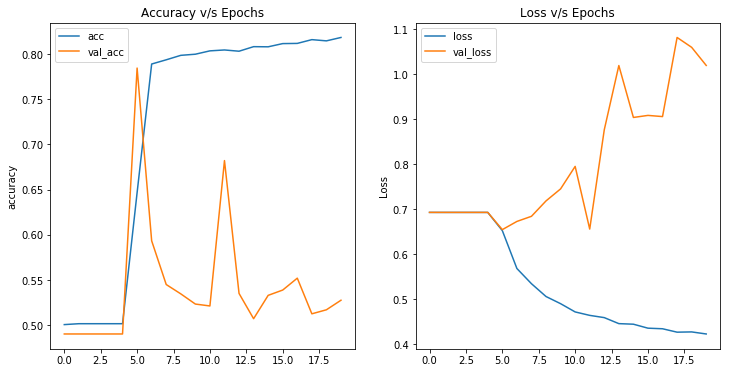

In [43]:
#Let us now plot and visulize the results
fig, ax = plt.subplots(1,2, figsize=(12,6))
df = pd.DataFrame(history_model_regCNN.history)
_ = ax[0].plot(df.acc)
_ = ax[0].plot(df['val_acc'])
_ = ax[1].plot(df.loss)
_ = ax[1].plot(df['val_loss'])
_ = ax[1].set_ylabel("Loss")
_ = ax[0].set_ylabel("accuracy")
_ = ax[0].legend()
_ = ax[1].legend()
_ = ax[0].set_title("Accuracy v/s Epochs")
_ = ax[1].set_title("Loss v/s Epochs")

As we can observe, there is a huge difference in the accuracy for a ResNet model and a regular Deep Model. We were able to achieve about 85% accuracy with a Resnet model and around 50% accuracy with a regular deep model with rest of the same architecture.

We will use ResNet model (with Dropouts) - 'model_rnn_drop' to be our final model, and evaluates the final performance on test set that we created.

In [0]:
#Performing the necessary transformations
y_test = keras.utils.to_categorical(y_test, 2)
X_test = X_test/255

In [45]:
#Performing the evaluation
score = model_rnn_drop.evaluate(X_test, y_test)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

14195/14195 [==============================] - 3s 182us/step
Test loss: 0.566
Test Accuracy: 0.744


As we can see from the above, our final model has an accuracy score of 0.744 on the test set, which in context of the given problem and dataset is a fairly good result.